# Pulse Level Learning

In this notebook, we will train a reinforcement learning agent to learn pulse level control of a quantum system. The configuration is drawn from two dedicated yaml files respectively describing the quantum environment and the agent. The quantum environment is a `QuantumEnvironment` object, which is a subclass of `gym.Env ` and is designed to be compatible with standard RL libraries. The agent on the other hand, is specifically hard coded for our need because of the need to be able to send to the same resource (the Estimator primitive) a batch of quantum circuits (in contrast with usual RL frameworks where actions can be evaluated in parallel).

For this notebook, we take all necessary inputs from the `pulse_config.py` file. This python file contains all elements necessary to create a pulse-level quantum environment. The file contains the following elements:
- a parametrized gate function, coded through Qiskit; leveraging behind the scenes a custom parametrized pulse schedule, to be inserted in the quantum circuit. The function needs to modify an input parametrized quantum circuit, by appending the parametrized gate to it.
- a Qiskit backend object, which is the quantum device or simulator on which the quantum circuits will be executed. The backend is retrieved through another template function called get_backend.
- A circuit context, which is a `QuantumCircuit` object that contains the quantum circuit in which the target gate operation should be optimized. The context is used to create the `ContextAwareQuantumEnvironment` object, which is a subclass of `BaseQuantumEnvironment` that takes into account the context of the quantum circuit in which the gate is to be optimized. Note that this mode is optional, as one could just focus on optimizing the gate operation in a standalone manner (i.e., without any context).

We provide a dedicated template for IBM devices working through ECR, X, and SX basis gates. The user can adapt this to the platform and basis gates of his choice.

In [1]:
from qiskit.primitives import BackendEstimatorV2

%matplotlib inline

from pulse_level.qiskit_pulse.x_calibration.pulse_config import (
    get_circuit_context,
    get_backend,
    apply_parametrized_circuit,
)
from rl_qoc import ContextAwareQuantumEnvironment, QuantumEnvironment, CustomPPO
from gymnasium.wrappers import RescaleAction, ClipAction
from qiskit.circuit import QuantumCircuit
from rl_qoc.helper_functions import (
    simulate_pulse_schedule,
    load_from_yaml_file,
    get_q_env_config,
)
import numpy as np
import os

# QuantumEnvironment setup

In [2]:
current_dir = os.getcwd()
config_file_name = "q_env_pulse_config.yml"
config_file_address = os.path.join(current_dir, config_file_name)

q_env_config = get_q_env_config(
    config_file_address,
    get_backend,
    apply_parametrized_circuit,
)
q_env_config.backend_config.parametrized_circuit_kwargs = {
    "target": q_env_config.target,
    "backend": q_env_config.backend,
}
circuit_context = get_circuit_context(
    q_env_config.backend, q_env_config.physical_qubits
)

Custom backend used
Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
All single qubit calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'sx', 'h', 'z', 'sdg', 'id', 'rz', 's', 'x', 'delay', 'measure', 'reset', 'tdg', 't'}
Multi qubit instructions:
)>
Circuit context: 
     ┌───┐ ░      ┌───┐     
q_0: ┤ H ├─░───■──┤ H ├──■──
     └───┘ ░ ┌─┴─┐└───┘┌─┴─┐
q_1: ──────░─┤ X ├─────┤ X ├
           ░ └───┘     └───┘


In [3]:
# Set the use_context flag to True if you want to use the context of the quantum circuit
use_context = False

if use_context:
    q_env = ContextAwareQuantumEnvironment(
        q_env_config, circuit_context, training_steps_per_gate=250
    )
else:
    q_env = QuantumEnvironment(q_env_config)

# Rescale the action space to [-1, 1] and clip the actions to the valid range
# This step is dependent on the output layer of the agent for the mean of the policy
# If the output layer is a tanh layer (default), then rescaling is necessary
rescaled_env = RescaleAction(ClipAction(q_env), -1.0, 1.0)

In [4]:
from qiskit.visualization import plot_circuit_layout

print("Available operations", q_env.backend.operation_names)
try:
    plot_circuit_layout(circuit_context, backend=q_env.backend)
except:
    print("No layout available")

Available operations ['measure', 'z', 's', 'sdg', 't', 'tdg', 'rz', 'id', 'h', 'x', 'sx', 'reset', 'delay', 'x_cal']
No layout available


In [5]:
from pathlib import Path

# Change the file_name to the name of the agent configuration file and specify the file location
file_name = "agent_config.yaml"
file_location = Path.cwd() / file_name

agent_config = load_from_yaml_file(file_location)

In [6]:
ppo_agent = CustomPPO(agent_config, rescaled_env)

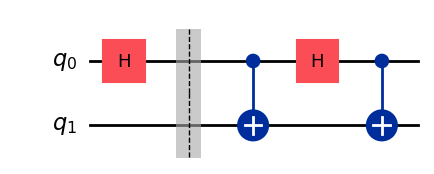

In [7]:
circuit_context.draw("mpl")

In [8]:
q_env.baseline_circuits[0]

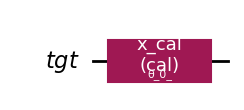

In [9]:
circuit = q_env.circuits[0]
circuit.draw("mpl")

In [10]:
from qiskit.qasm3 import dumps

dumps(circuit, basis_gates=("x_cal",), includes=())

'OPENQASM 3.0;\ninput float[64] θ_0_;\nqubit[1] tgt;\nx_cal(θ_0_) tgt[0];\n'

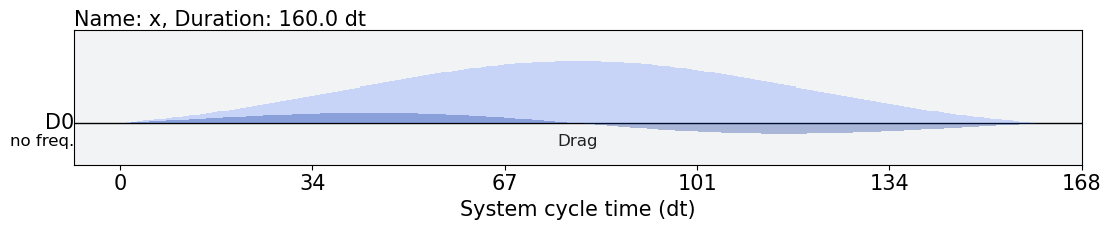

In [11]:
q_env.backend.target.get_calibration("x", (0,)).draw()

In [12]:
qc = QuantumCircuit(1)
qc.sx(0)
qc.measure_all()
q_env.backend.run(qc).result().get_counts()

{'0': 515, '1': 509}

In [13]:
from rl_qoc.ppo_config import TotalUpdates, TrainFunctionSettings, TrainingConfig

total_updates = TotalUpdates(500)
# hardware_runtime = HardwareRuntime(300)
training_config = TrainingConfig(
    training_constraint=total_updates,
    target_fidelities=[0.999, 0.9999],
    lookback_window=10,
    anneal_learning_rate=True,
    std_actions_eps=1e-2,
)

train_function_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=True,
    num_prints=1,
    hpo_mode=False,
    clear_history=True,
)

In [14]:
ppo_agent.ent_coef = 0.01

In [15]:
ppo_agent.train(
    training_config=training_config, train_function_settings=train_function_settings
)

2024-10-15 14:51:23 INFO Training Constraint: Total Updates


  0%|          | 0/500 [00:00<?, ?it/s]/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/base_q_env.py:1585: ComplexWarning: Casting complex values to real discards the imaginary part
  array_obs[pauli_to_index[pauli.paulis[0]]] = pauli.coeffs[0]
  0%|          | 0/500 [00:00<?, ?it/s]

Starting simulation benchmark...


PulseError: 'Unassigned parameter exists. All parameters must be assigned.'

In [ ]:
import matplotlib.pyplot as plt

plt.plot(ppo_agent.training_results["std_action"])

In [20]:
plt.plot(ppo_agent.training_results["action_history"])

NameError: name 'plt' is not defined

In [21]:
from rl_qoc import GateTarget

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4
n_epochs = len(mean_rewards)
if q_env.benchmark_cycle != 0:
    fidelity_range = np.arange(0, n_epochs, q_env.benchmark_cycle)
plt.plot(
    # fidelity_range,
    np.array(q_env.fidelity_history),
    label=f"Average {q_env.target.target_type} Fidelity",
)
plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")

plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name if isinstance(q_env.target, GateTarget) else ''} Learning Curve"
)
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [22]:
print("Optimal action", q_env.optimal_action)
print("Best fidelity:", np.max(q_env.fidelity_history))

Optimal action [0.42172456]
Best fidelity: 0.9797650919094828


In [23]:
cal = q_env.backend.target.get_calibration("x", (0,))
from pulse_level.qiskit_pulse.x_calibration.pulse_config import custom_schedule

cal = custom_schedule(
    q_env.backend, q_env.physical_target_qubits, q_env.parameters
).assign_parameters({q_env.parameters: q_env.optimal_action.tolist()})
data = simulate_pulse_schedule(
    q_env.backend, cal, target_unitary=q_env.target.target_operator
)

print(data)

{'unitary': Operator([[ 0.46137567-0.65855256j,  0.31988325+0.50121816j,
           -0.00177893+0.00139846j],
          [ 0.32012269+0.50106571j,  0.79151657-0.14148161j,
            0.00192694+0.00625076j],
          [-0.00130617-0.0016074j , -0.00627511+0.00205826j,
            0.42073052+0.90721302j]],
         input_dims=(3,), output_dims=(3,)), 'state': DensityMatrix([[ 6.46558984e-01-2.68900089e-17j,
                -1.82281286e-01-4.41997144e-01j,
                 4.55926977e-04+1.60179588e-03j],
               [-1.82281286e-01+4.41997144e-01j,
                 3.53545381e-01+9.72144524e-18j,
                -1.22354832e-03-1.39908333e-04j],
               [ 4.55926977e-04-1.60179588e-03j,
                -1.22354832e-03+1.39908333e-04j,
                 4.28981656e-06-1.30078059e-22j]],
              dims=(3,)), 'projected_unitary': Operator([[0.46137567-0.65855256j, 0.31988325+0.50121816j],
          [0.32012269+0.50106571j, 0.79151657-0.14148161j]],
         input_dims=(2,), 

In [24]:
# Plot the fidelity as a function of the amplitude (for X gate)
amp_range = np.linspace(-1, 1, 500)
fidelity_range = []
for amp in amp_range:
    cal = custom_schedule(
        q_env.backend, q_env.physical_target_qubits, q_env.parameters
    ).assign_parameters({q_env.parameters: [amp]})
    data = simulate_pulse_schedule(
        q_env.backend, cal, target_unitary=q_env.target.target_operator
    )
    fidelity_range.append(data["gate_fidelity"]["raw"])
plt.plot(amp_range, fidelity_range)

KeyboardInterrupt: 

In [22]:
from rl_qoc.helper_functions import perform_standard_calibrations

cals, exp = perform_standard_calibrations(q_env.backend)

Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
All single qubit calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'z', 't', 'id', 'measure', 'tdg', 'reset', 'x_cal', 'delay', 'rz', 'h', 'x', 'sx', 'sdg', 's'}
Multi qubit instructions:
)>


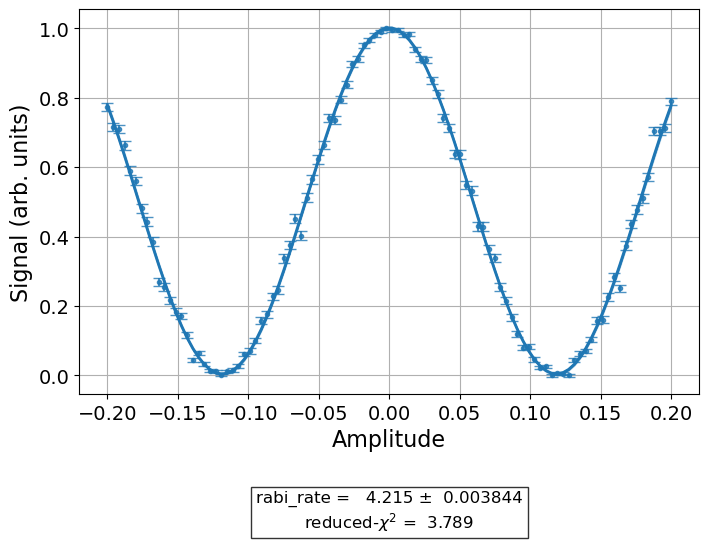

In [23]:
exp[0][0].figure(0)

In [24]:
cals.parameters_table(["amp"])

{'data': [{'value': 0.5,
   'date_time': '2024-09-06 16:56:33.996814+0800',
   'valid': True,
   'exp_id': None,
   'group': 'default',
   'qubits': (),
   'parameter': 'amp',
   'schedule': 'x'},
  {'value': 0.11861636,
   'date_time': '2024-09-06 16:56:34.405950+0800',
   'valid': True,
   'exp_id': '49f98443-ed84-4d79-975b-0ba7ccdded9e',
   'group': 'default',
   'qubits': (0,),
   'parameter': 'amp',
   'schedule': 'x'},
  {'value': 0.25,
   'date_time': '2024-09-06 16:56:33.996825+0800',
   'valid': True,
   'exp_id': None,
   'group': 'default',
   'qubits': (),
   'parameter': 'amp',
   'schedule': 'sx'},
  {'value': 0.05930818,
   'date_time': '2024-09-06 16:56:34.405950+0800',
   'valid': True,
   'exp_id': '49f98443-ed84-4d79-975b-0ba7ccdded9e',
   'group': 'default',
   'qubits': (0,),
   'parameter': 'amp',
   'schedule': 'sx'}],
 'columns': ['parameter',
  'qubits',
  'schedule',
  'value',
  'group',
  'valid',
  'date_time',
  'exp_id']}

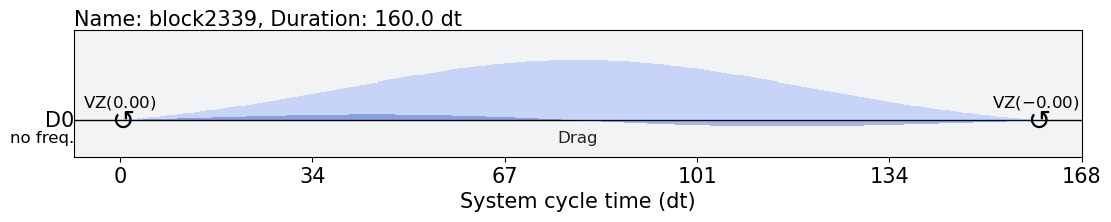

In [25]:
# Update the gate calibration in the backend target and retrieve the calibration
optimal_calibration = q_env.update_gate_calibration()
q_env.backend.target.get_calibration("x", (0,)).draw()

In [26]:
from qiskit.quantum_info import Operator, Statevector

data = simulate_pulse_schedule(
    q_env.backend,
    optimal_calibration,
    target_unitary=Operator(q_env.target["gate"]),
)

print(data)

TypeError: 'GateTarget' object is not subscriptable

In [2]:
# Testing gate in a quantum circuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit import transpile

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
qc.draw("mpl")

basic_simulator = BasicSimulator()
basic_result = basic_simulator.run(qc).result()

pulse_circ = transpile(qc, q_env.backend)
q_env.backend.options.shots = 1000
pulse_results = q_env.backend.run(pulse_circ).result()

print("BasicProvider: ", basic_result.get_counts())
print("Custom Backend:", pulse_results.get_counts())

NameError: name 'QuantumCircuit' is not defined

In [ ]:
pulse_circ.draw("mpl")

In [ ]:
# Testing the pulse schedule
from qiskit import schedule

pulse_schedule = schedule(
    pulse_circ.remove_final_measurements(inplace=False), q_env.backend
)
pulse_schedule.draw()

In [ ]:
# Testing the pulse schedule
pulse_sim_results = simulate_pulse_schedule(
    q_env.backend,
    pulse_schedule,
    target_unitary=Operator(pulse_circ.remove_final_measurements(inplace=False)),
    target_state=(Statevector.from_label("00") + Statevector.from_label("11"))
                 / np.sqrt(2),
)
print(pulse_sim_results)

In [ ]:
new_circ = transpile(
    pulse_circ.remove_final_measurements(inplace=False),
    q_env.backend,
    scheduling_method="asap",
)
new_circ.draw("mpl")

In [ ]:
new_circ.op_start_times

In [ ]:
instruction_list = []
for instruction in new_circ.data:
    instruction_list.append(instruction.operation.name)
instruction_list

In [ ]:
from rl_qoc.helper_functions import new_params_ecr
from pulse_level.qiskit_pulse.x_calibration.pulse_config import custom_schedule

new_params_ecr(
    q_env.parameters[0],
    tuple(q_env.physical_target_qubits),
    q_env.backend,
    ["amp", "tgt_amp", "angle", "tgt_angle"],
)

custom_schedule(q_env.backend, q_env.physical_target_qubits, q_env.parameters[0])

In [8]:
from rl_qoc.custom_jax_sim.pulse_estimator_v2 import PulseEstimatorV2
from qiskit.primitives.containers.estimator_pub import EstimatorPub
from qiskit.circuit import Parameter
from qiskit import transpile

q_env.backend.options.solver_options["atol"] = 1e-8
q_env.backend.options.solver_options["rtol"] = 1e-8
q_env.backend.options.solver_options["hmax"] = 1e-10
estimator = PulseEstimatorV2(backend=q_env.backend)
param = Parameter("amp")
qc = QuantumCircuit(1)
qc.rx(np.pi, 0)
qc = transpile(qc, q_env.backend)
job = estimator.run([(qc, "Z")])

In [36]:
job2 = estimator._run_pub(EstimatorPub.coerce((qc, "Z", [[np.pi], [np.pi / 2]])))

KeyboardInterrupt: 

In [9]:
job.result()[0].data.evs

array(-0.92723886)

In [33]:
result = job.result()[0]

In [34]:
np.linalg.norm(job.result()[0].metadata["simulated_statevectors"][0])

1.0000000659590926

In [26]:
from qiskit.quantum_info import Statevector, Pauli

Statevector(
    [0.02192868 + 0.28788927j, -0.04495291 - 0.9563567j], dims=(2,)
).expectation_value(Pauli("Z"))

-0.8332778029646827

In [28]:
result.metadata

{'target_precision': 0.015625,
 'circuit_metadata': {},
 'simulated_statevectors': [Statevector([-1.54242505e-03+0.01524945j,  9.99632417e-01-0.02234486j,
                5.98533986e-04-0.00076669j],
              dims=(3,))],
 'simulated_qubitized_statevectors': [Statevector([-0.00154243+0.01524945j,  0.99963282-0.02234487j],
              dims=(2,))]}